c:\Users\Windows11\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Model saved for environment Pendulum-v1 at episode 46
达到收敛条件，提前退出训练


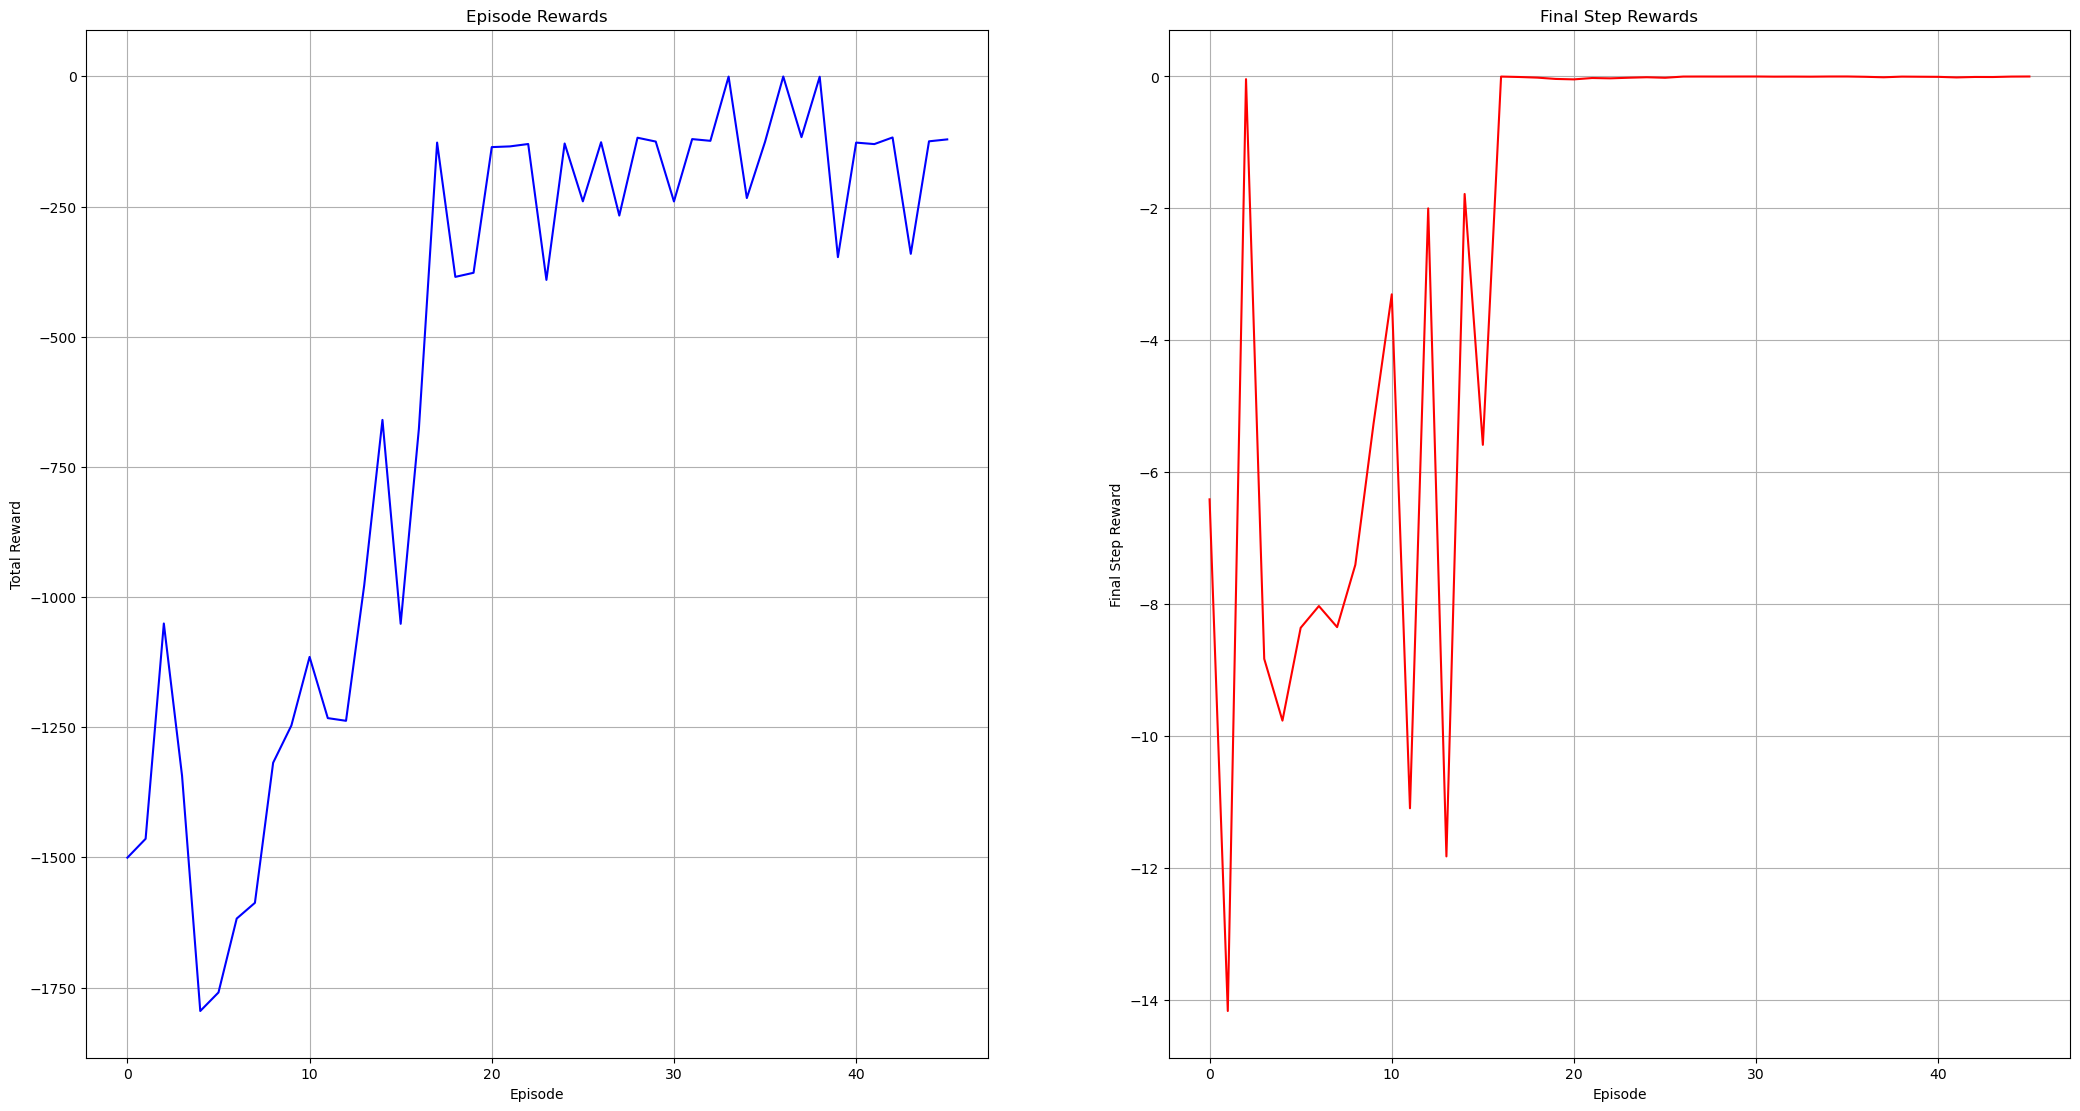

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# 超参数
BUFFER_SIZE = 100000  # 经验回放缓冲区大小
BATCH_SIZE = 128      # 每次训练的批量大小
GAMMA = 0.99          # 折扣因子
TAU = 0.01           # 目标网络软更新系数
LR_ACTOR = 0.001      # Actor 学习率
LR_CRITIC = 0.002     # Critic 学习率
MAX_EPISODES = 200    # 最大训练回合数
MAX_STEPS = 200       # 每回合最大步数
# TD3超参数
POLICY_NOISE = 0.2    # 策略噪声
NOISE_CLIP = 0.5      # 噪声裁剪
POLICY_FREQ = 2       # 策略更新频率
env_name = "Pendulum-v1"  # 环境名称

# 设备选择
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        # 可训练参数
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))

        # 噪声参数
        self.register_buffer("weight_epsilon", torch.Tensor(out_features, in_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        # 初始化可训练参数
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def reset_noise(self):
        # 生成噪声
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        # 生成随机噪声
        noise = torch.randn(size)
        return noise.sign().mul(noise.abs().sqrt())

    def forward(self, x):
        # 前向传播时加入噪声
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)
    
# Actor 网络
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = NoisyLinear(state_dim, 256)  # 使用 NoisyLinear
        self.fc2 = NoisyLinear(256, 256)        # 使用 NoisyLinear
        self.fc3 = nn.Linear(256, action_dim)   # 最后一层不使用噪声
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = self.max_action * torch.tanh(self.fc3(x))  # 输出在 [-max_action, max_action] 之间
        return action

    def reset_noise(self):
        # 重置噪声
        self.fc1.reset_noise()
        self.fc2.reset_noise()

# Critic 网络
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

# 经验回放缓冲区
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(np.array(states)).to(device),            # 形状: (batch_size, state_dim)
            torch.FloatTensor(np.array(actions)).to(device),          # 形状: (batch_size, action_dim)
            torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device),  # 形状: (batch_size, 1)
            torch.FloatTensor(np.array(next_states)).to(device),      # 形状: (batch_size, state_dim)
            torch.FloatTensor(np.array(dones)).unsqueeze(1).to(device),    # 形状: (batch_size, 1)
        )

    def __len__(self):
        return len(self.buffer)

class TD3:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)

        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        self.critic_optimizer = optim.Adam(list(self.critic1.parameters()) + list(self.critic2.parameters()), lr=LR_CRITIC)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
        self.policy_delay = POLICY_FREQ  # 延迟更新 Actor 的频率
        self.noise_clip = NOISE_CLIP  # 目标策略平滑噪声的裁剪范围
        self.policy_noise = POLICY_NOISE  # 目标策略平滑噪声的标准差
        self.total_iterations = 0

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action = self.actor(state).cpu().data.numpy().flatten()
        #action = (action + np.random.normal(0, noise, size=action.shape)).clip(-self.max_action, self.max_action)
        return action

    def train(self):
        if len(self.replay_buffer) < BATCH_SIZE:
            return

        # 从缓冲区采样
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(BATCH_SIZE)

        # 计算目标 Q 值
        with torch.no_grad():
            noise = (torch.randn_like(actions) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_actions = (self.actor_target(next_states) + noise).clamp(-self.max_action, self.max_action)
            target_q1 = self.critic1_target(next_states, next_actions)
            target_q2 = self.critic2_target(next_states, next_actions)
            target_q = rewards + (1 - dones) * GAMMA * torch.min(target_q1, target_q2)

        # 更新 Critic 网络
        current_q1 = self.critic1(states, actions)
        current_q2 = self.critic2(states, actions)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 延迟更新 Actor 网络
        if self.total_iterations % self.policy_delay == 0:
            actor_loss = -self.critic1(states, self.actor(states)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # 软更新目标网络
            for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
            for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

        self.total_iterations += 1

# 主函数
def main():
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    td3Agent = TD3(state_dim, action_dim, max_action)

    # qt弹窗显示
    %matplotlib qt
    # 初始化动态绘图
    plt.ion()  # 开启交互模式
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("Episode Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total Reward")
    line1, = ax1.plot([], [], color="blue")
    ax1.grid(True)
    ax2.set_title("Final Step Rewards")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Final Step Reward")
    line2, = ax2.plot([], [], color="red")
    ax2.grid(True)

    episode_rewards = []  # 存储每个回合的总奖励
    final_step_rewards = []  # 存储每个回合的最后一步奖励

    # 监控参数
    success_count = 0

    for episode in range(MAX_EPISODES):
        state = env.reset()[0]
        episode_reward = 0
        final_reward = 0

        for step in range(MAX_STEPS):
            # 重置噪声
            td3Agent.actor.reset_noise()
            action = td3Agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            td3Agent.replay_buffer.add(state, action, reward, next_state, 0) # 游戏没有终止状态，所以dones为0
            state = next_state
            episode_reward += reward
            final_reward = reward  # 记录最后一步的奖励

            td3Agent.train()

            if done:
                break

        episode_rewards.append(episode_reward)
        final_step_rewards.append(final_reward)

        #print(f"Episode: {episode + 1}, Total Reward: {episode_reward}, Final Step Reward: {final_reward}")

        # 更新图像
        line1.set_data(range(len(episode_rewards)), episode_rewards)
        ax1.relim()
        ax1.autoscale_view()
        line2.set_data(range(len(final_step_rewards)), final_step_rewards)
        ax2.relim()
        ax2.autoscale_view()

        plt.pause(0.025)  # 短暂暂停以更新图像

        # 监控训练过程，视情况提前退出，并保存模型
        if episode_reward > -400:
            success_count += 1
            if success_count >= 20 and final_reward > -0.001:
                # 保存模型：环境名称+模型名称
                torch.save(td3Agent.actor.state_dict(), f"{env.spec.id}_TD3_actor.pth")
                torch.save(td3Agent.critic1.state_dict(), f"{env.spec.id}_TD3_critic1.pth")
                torch.save(td3Agent.critic2.state_dict(), f"{env.spec.id}_TD3_critic2.pth")
                print(f"Model saved for environment {env.spec.id} at episode {episode + 1}")
                print(f"达到收敛条件，提前退出训练")
                break
        else:
            success_count = 0


    plt.ioff()  # 关闭交互模式
    # 重新设置为行内显示
    %matplotlib inline
    plt.show()
    env.close()

if __name__ == "__main__":
    main()

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
c:\Users\Windows11\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


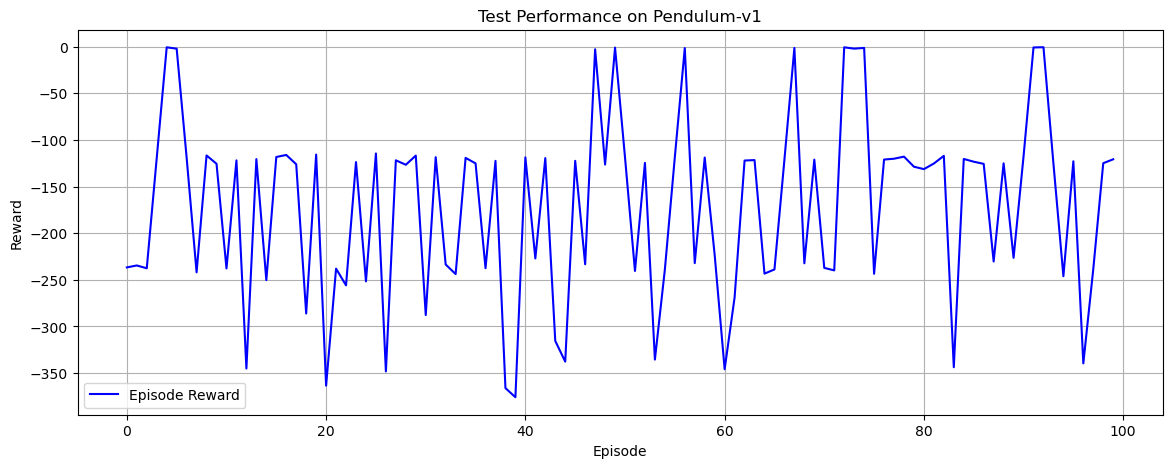

In [2]:
import pygame
# 加载模型
def load_model(env_name, state_dim, action_dim, max_action):
    actor = Actor(state_dim, action_dim, max_action).to(device)
    actor.load_state_dict(torch.load(f"{env_name}_TD3_actor.pth", weights_only=True))
    actor.eval()  # 设置为评估模式
    return actor

# 测试函数
def test_model(env_name, test_episodes, max_steps, render_mode=None):
    env = gym.make(env_name, render_mode=render_mode)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # 加载训练好的 Actor 模型
    actor = load_model(env_name, state_dim, action_dim, max_action)

    episode_rewards = []  # 存储每个回合的奖励
    rewards_history = []  # 存储每个回合的奖励历史

    bExit = False

    for episode in range(test_episodes):
        state = env.reset()[0]
        episode_reward = 0
        rewards_history.append([])

        for step in range(max_steps):
            # 选择动作（无探索噪声）
            state_tensor = torch.FloatTensor(state.reshape(1, -1)).to(device)
            action = actor(state_tensor).cpu().data.numpy().flatten()

            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            rewards_history[episode].append(reward)
            state = next_state

            if done:
                break

            if render_mode == "human":
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        bExit = True
                    # 按下esc键退出
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            bExit = True

        episode_rewards.append(episode_reward)
        #print(f"Test Episode: {episode + 1}, Reward: {episode_reward}")
        if bExit:
            print(f"按下ESC, 提前退出测试")
            break

    env.close()

    # 绘制回合奖励图像
    plt.figure(figsize=(14, 5))
    plt.plot(episode_rewards, color="blue", label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"Test Performance on {env_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return rewards_history

# 主函数
if __name__ == "__main__":
    rewards_history = test_model(env_name, 100, MAX_STEPS, render_mode=None) # render_mode=None 表示不渲染, render_mode="human" 表示渲染

In [3]:
# 绘制奖励曲线
%matplotlib qt
plt.plot(rewards_history[0])
plt.xlabel('Step')
plt.ylabel('Reward')
# 网格线
plt.grid(True)
plt.show()

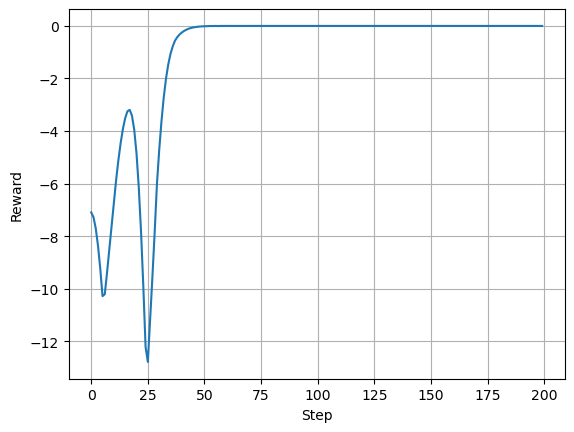

In [4]:
# 绘制奖励曲线
%matplotlib inline
plt.plot(rewards_history[0])
plt.xlabel('Step')
plt.ylabel('Reward')
# 网格线
plt.grid(True)
plt.show()